# Hands-on session with pke - part 1

This notebook covers a brief introduction on keyphrase extraction using `pke`, an open source python-based keyphrase extraction toolkit. `pke` provides an end-to-end keyphrase extraction pipeline in which each component can be easily modified or extented to develop new models.

The overall architecture of `pke` is depicted in the Figure below.
Extracting keyphrases from an input document involves three stages.
First, **keyphrase candidates** (i.e. words and phrases that are eligible to be keyphrases) are selected from the content of the document (populates the `self.candidates` dictionary). Second, **candidates are either ranked** using a candidate weighting function (unsupervised approaches), **or classified as keyphrase or not** using a set of extracted features (supervised approaches) (populates the `self.weights` dictionary). Third, the top-N highest weighted candidates, or those classified as keyphrase with the highest confidence scores, are selected as keyphrases.

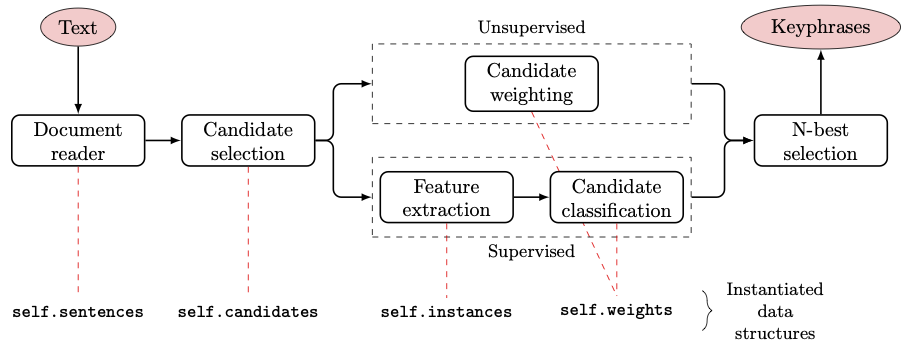

`pke` provides a standardized API for extracting keyphrases from a document:

```python
import pke

extractor = pke.unsupervised.TfIdf()                # initialize a keyphrase extraction model, here TFxIDF
extractor.load_document(input='text')               # load the content of the document  (str or spacy Doc)
extractor.candidate_selection()                     # identify keyphrase candidates
extractor.candidate_weighting()                     # weight keyphrase candidates
keyphrases = extractor.get_n_best(n=10)             # select the 10-best candidates as keyphrases
```

## Graph-based keyphrase extraction with TopicRank

[TopicRank (Bougouin et al., 2013)](https://aclanthology.org/I13-1062/) is an unsupervised graph-based ranking model to keyphrase extraction that is often used as a baseline by the research community.
TopicRank relies on a graph-based topical representation of the input document, and uses a random walk algorithm derived from PageRank to estimate the importance of each topic (node).
The most representative phrase candidates belonging to the highest-scored topics are then selected as keyphrases.

This notebook presents an end-to-end example of keyphrase extraction using TopicRank implemented in `pke`.

### step-1: let's start by importing `pke` and initializing a `TopicRank` model

In [1]:
import pke

# initialize a TopicRank keyphrase extraction model
extractor = pke.unsupervised.TopicRank()

### step-2: what we need now is a sample document

In [2]:
# sample document (2040.abstr from the Hulth-2003 dataset)
sample = """Inverse problems for a mathematical model of ion exchange in a compressible ion exchanger.
A mathematical model of ion exchange is considered, allowing for ion exchanger compression in the process
of ion exchange. Two inverse problems are investigated for this model, unique solvability is proved, and
numerical solution methods are proposed. The efficiency of the proposed methods is demonstrated by a
numerical experiment.""".replace("\n", " ")

### step-3: we can load the sample document using the pke model

When raw text is given to a `pke` model, `spacy`/`nltk` is used to pre-process the text (sentence splitting, tokenization, Part-of-Speech tagging, stemming).

In [3]:
# load the document using the initialized model
# text preprocessing is carried out using spacy
extractor.load_document(input=sample, language='en')

In [4]:
# loading a document populates the extractor.sentences list
# let's have a look at the pre-processed text

# for each sentence in the document
for i, sentence in enumerate(extractor.sentences):
    
    # print out the sentence id, its tokens, its stems and the corresponding Part-of-Speech tags
    print("sentence {}:".format(i))
    print(" - words: {} ...".format(' '.join(sentence.words[:5])))
    print(" - stems: {} ...".format(' '.join(sentence.stems[:5])))
    print(" - PoS: {} ...".format(' '.join(sentence.pos[:5])))

sentence 0:
 - words: Inverse problems for a mathematical ...
 - stems: inverse problems for a mathematical ...
 - PoS: NOUN NOUN ADP DET ADJ ...
sentence 1:
 - words: A mathematical model of ion ...
 - stems: a mathematical model of ion ...
 - PoS: DET ADJ NOUN ADP NOUN ...
sentence 2:
 - words: Two inverse problems are investigated ...
 - stems: two inverse problems are investigated ...
 - PoS: NUM NOUN NOUN AUX VERB ...
sentence 3:
 - words: The efficiency of the proposed ...
 - stems: the efficiency of the proposed ...
 - PoS: DET NOUN ADP DET VERB ...


### step-4 : identifying keyphrase candidates

In [5]:
# identify the keyphrase candidates using TopicRank's default strategy
# i.e. the longest sequences of nouns and adjectives `(Noun|Adj)*`
extractor.candidate_selection()

In [6]:
# identifying keyphrase candidates populates the extractor.candidates dictionary
# let's have a look at the keyphrase candidates

# for each keyphrase candidate
for i, candidate in enumerate(extractor.candidates):
    
    # print out the candidate id, its stemmed form 
    print("candidate {}: {} (stemmed form)".format(i, candidate))
    
    # print out the surface forms of the candidate
    print(" - surface forms:", [ " ".join(u) for u in extractor.candidates[candidate].surface_forms])
    
    # print out the corresponding offsets
    print(" - offsets:", extractor.candidates[candidate].offsets)
    
    # print out the corresponding sentence ids
    print(" - sentence_ids:", extractor.candidates[candidate].sentence_ids)
    
    # print out the corresponding PoS patterns
    print(" - pos_patterns:", extractor.candidates[candidate].pos_patterns)

candidate 0: inverse problems (stemmed form)
 - surface forms: ['Inverse problems', 'inverse problems']
 - offsets: [0, 37]
 - sentence_ids: [0, 2]
 - pos_patterns: [['NOUN', 'NOUN'], ['NOUN', 'NOUN']]
candidate 1: mathematical model (stemmed form)
 - surface forms: ['mathematical model', 'mathematical model']
 - offsets: [4, 16]
 - sentence_ids: [0, 1]
 - pos_patterns: [['ADJ', 'NOUN'], ['ADJ', 'NOUN']]
candidate 2: ion exchange (stemmed form)
 - surface forms: ['ion exchange', 'ion exchange', 'ion exchange']
 - offsets: [7, 19, 33]
 - sentence_ids: [0, 1, 1]
 - pos_patterns: [['NOUN', 'NOUN'], ['NOUN', 'NOUN'], ['NOUN', 'NOUN']]
candidate 3: compressible ion exchanger (stemmed form)
 - surface forms: ['compressible ion exchanger']
 - offsets: [11]
 - sentence_ids: [0]
 - pos_patterns: [['NOUN', 'NOUN', 'ADJ']]
candidate 4: ion exchanger compression (stemmed form)
 - surface forms: ['ion exchanger compression']
 - offsets: [26]
 - sentence_ids: [1]
 - pos_patterns: [['NOUN', 'NOUN', '

### step-5 : ranking keyphrase candidates

In [7]:
# In TopicRank, candidate weighting is a three-step process:
#  1. candidate clustering (grouping keyphrase candidates into topics)
#  2. graph construction (building a complete-weighted-graph of topics)
#  3. rank topics (nodes) using a random walk algorithm
extractor.candidate_weighting()

In [8]:
# let's have a look at the topics

# for each topic of the document
for i, topic in enumerate(extractor.topics):
    
    # print out the topic id and the candidates it groups together
    print("topic {}: {} ".format(i, ';'.join(topic)))

topic 0: methods;numerical solution methods 
topic 1: numerical experiment 
topic 2: mathematical model;model 
topic 3: compressible ion exchanger;ion exchanger compression 
topic 4: ion exchange 
topic 5: efficiency 
topic 6: inverse problems 
topic 7: process 
topic 8: unique solvability 


<IPython.core.display.Javascript object>


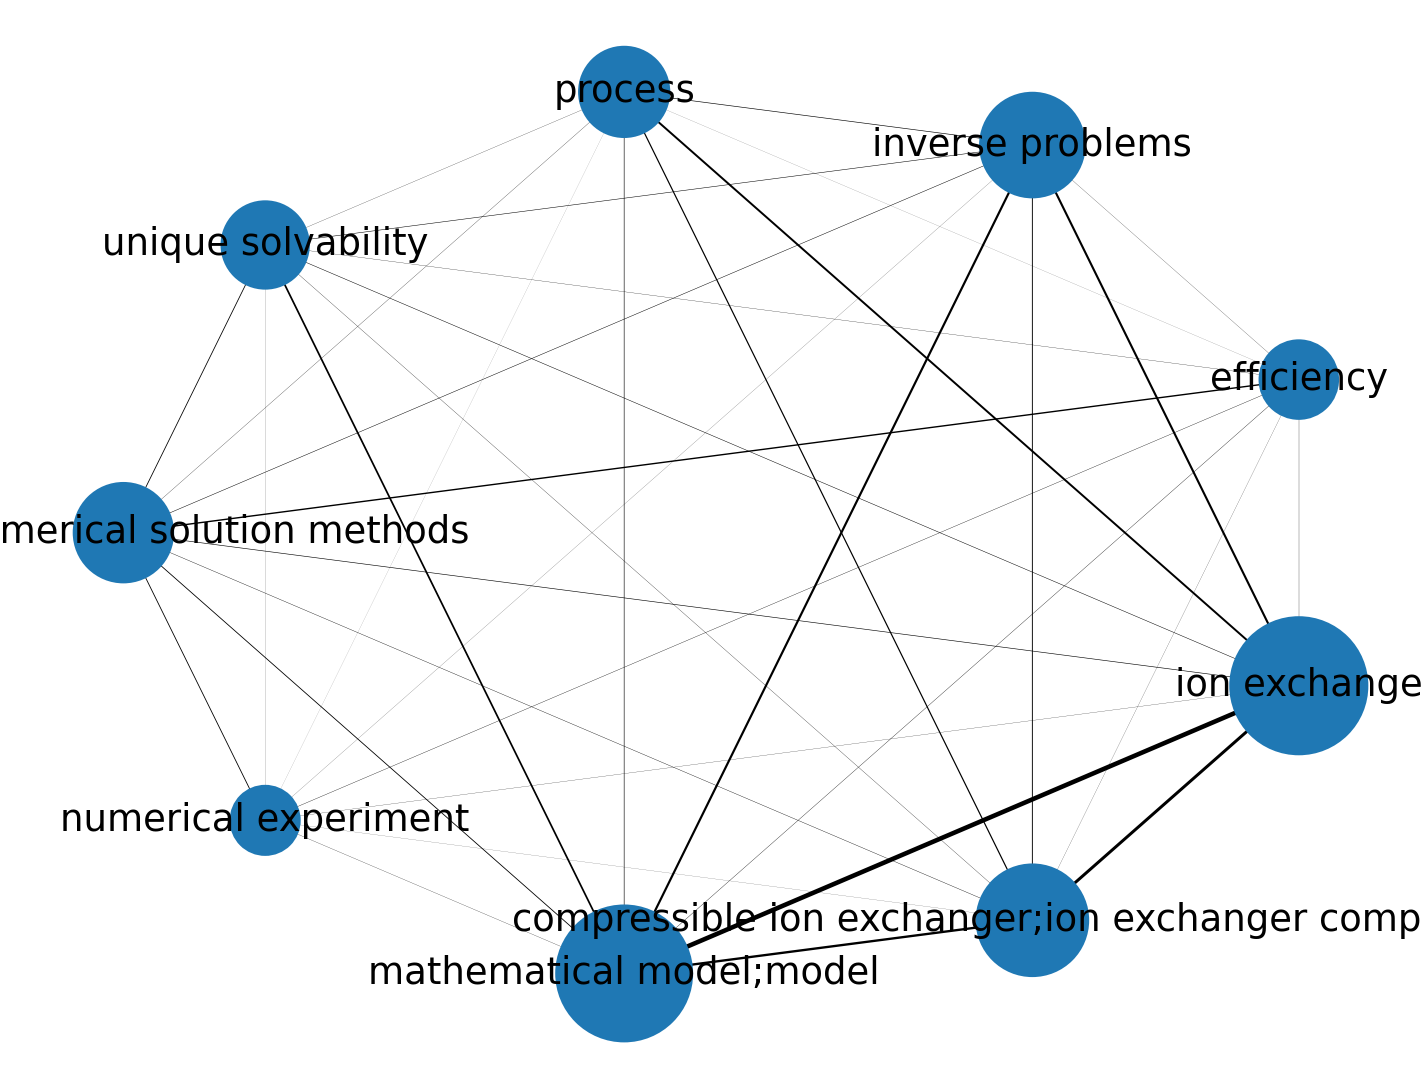

In [9]:
# let have a look at the graph-based representation of the document
#
# here, nodes are topics, edges between topics are weighted according to 
# the strength of their semantic relation measured by the reciprocal distances
# between the offset positions of the candidate keyphrases

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

# set the labels as list of candidates for each topic
labels = {i: ';'.join(topic) for i, topic in enumerate(extractor.topics)}

# set the weights of the edges
edge_weights = [extractor.graph[u][v]['weight'] for u,v in extractor.graph.edges()]

# set the weights of the nodes (topic weights are stored in _w attribute)
sizes = [10e3*extractor._w[i] for i, topic in enumerate(extractor.topics)]

# draw the graph
nx.draw_shell(extractor.graph, with_labels=True, labels=labels, width=edge_weights, node_size=sizes)

In [10]:
# let's have a look at the weights/ranks of the topics

# In TopicRank, weights are computed for each topic, and only one
# representative candidate per topic (by default the first occurring
# one) is kept

# for each representative candidate
for candidate, weight in extractor.weights.items():
    
    # print out the candidate (in stemmed form) and its weight
    print('{}: {}'.format(candidate, weight))

numerical solution methods: 0.10147966919686371
numerical experiment: 0.04849286001037014
mathematical model: 0.19079217701942353
compressible ion exchanger: 0.12826237907688728
ion exchange: 0.19414317280264579
efficiency: 0.06292470145394607
inverse problems: 0.11246683345390965
process: 0.08340209877595584
unique solvability: 0.07803610820999785


### step-6: selecting the N-best candidates as keyphrases

In [11]:
# Get the N-best candidates (here, 5) as keyphrases
keyphrases = extractor.get_n_best(n=5, stemming=False)

# for each of the best candidates
for i, (candidate, score) in enumerate(keyphrases):
    
    # print out the its rank, phrase and score
    print("rank {}: {} ({})".format(i, candidate, score))

rank 0: ion exchange (0.19414317280264579)
rank 1: mathematical model (0.19079217701942353)
rank 2: compressible ion exchanger (0.12826237907688728)
rank 3: inverse problems (0.11246683345390965)
rank 4: numerical solution methods (0.10147966919686371)


## Conclusion

Now that we are familiar with the three-stage process involved in keyphrase extraction (candidate selection, candidate ranking, N-best selection), as well as with the `pke` API, we are ready for part-2 in which experiment with different models and parameters and see how to evaluate the quality of the produced keyphrases.